# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from scipy.io import loadmat
import os
from PINN_Plane_Stress import Model
torch.manual_seed(123456)
np.random.seed(123456)

In [2]:
DATA_DIR = 'data'
IMAGE_DIR = 'images'

# Solution to the Problem

## Loading Data and Creating Data

In [3]:
E = 1  # Young's Modulus
nu = 0.3  # Poisson Ratio
G = E / (2 * (1 + nu))  # Shear modulus

In [4]:
boundary_points = loadmat(os.path.join(DATA_DIR, 'boundary_points.mat'))
x_boundary = boundary_points['x_bdry']
y_boundary = boundary_points['y_bdry']
num_boundary_points = len(x_boundary)

In [5]:
interior_points = loadmat(os.path.join(DATA_DIR, 'interior_points.mat'))
x_interior = interior_points['x']
y_interior = interior_points['y']
num_interior_points = len(x_interior)

In [6]:
X_boundary = torch.tensor(np.concatenate((x_boundary, y_boundary), axis=1), dtype=torch.float32, requires_grad=True)
X_interior = torch.tensor(np.concatenate((x_interior, y_interior), axis=1), dtype=torch.float32, requires_grad=True)

X = torch.cat((X_boundary, X_interior), dim=0)
u_boundary = torch.tensor(np.zeros((num_boundary_points, 1)), dtype=torch.float32, requires_grad=True)
v_boundary = torch.tensor(np.zeros((num_boundary_points, 1)), dtype=torch.float32, requires_grad=True)
U_boundary = torch.cat((u_boundary, v_boundary), dim=1)
print(X.shape, U_boundary.shape)

torch.Size([2865, 2]) torch.Size([160, 2])


## Creating and Training the Model

In [7]:
# Initialize model
model = Model(X_interior=X_interior, X_boundary=X_boundary, U_boundary=U_boundary)

Sequential(
  (Linear_layer_1): Linear(in_features=2, out_features=30, bias=True)
  (Tanh_layer_1): Tanh()
  (Linear_layer_2): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_2): Tanh()
  (Linear_layer_3): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_3): Tanh()
  (Linear_layer_4): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_4): Tanh()
  (Linear_layer_5): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_5): Tanh()
  (Output_layer): Linear(in_features=30, out_features=2, bias=True)
)


In [8]:
# Loss and Optimizer
optimizer = optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=0.1,
    max_iter=100,
    max_eval=100,
    tolerance_grad=1e-05,
    tolerance_change=1e-06,
)

In [9]:
def train(epochs):
    for epoch in range(epochs):
        optimizer.zero_grad()
        l = model.loss()
        l.backward()

        def closure():
            optimizer.zero_grad()
            loss_ = model.loss()
            loss_.backward()
            return loss_

        optimizer.step(closure)
        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {l.item():.5f}")

In [10]:
train(epochs = 20)

Epoch 2/20, Loss: 1.23953
Epoch 4/20, Loss: 0.62425
Epoch 6/20, Loss: 0.40380
Epoch 8/20, Loss: 0.20536
Epoch 10/20, Loss: 0.11482
Epoch 12/20, Loss: 0.05795
Epoch 14/20, Loss: 0.03979
Epoch 16/20, Loss: 0.02226
Epoch 18/20, Loss: 0.01463
Epoch 20/20, Loss: 0.01060


In [11]:
torch.save(model.state_dict(), 'model.pt')

## Plotting the Results

In [12]:
x_mesh, y_mesh = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))
X_to_predict = torch.tensor(
    np.concatenate((x_mesh.reshape(-1, 1), y_mesh.reshape(-1, 1)), axis=1),
    dtype=torch.float32,
    requires_grad=True,
)
U_pred = model(X_to_predict)
u_pred = U_pred[:, 0].detach().numpy()
u_pred = u_pred.reshape(x_mesh.shape)
v_pred = U_pred[:, 1].detach().numpy()
v_pred = v_pred.reshape(x_mesh.shape)

In [13]:
EXTENT = [0, 1, 0, 1]

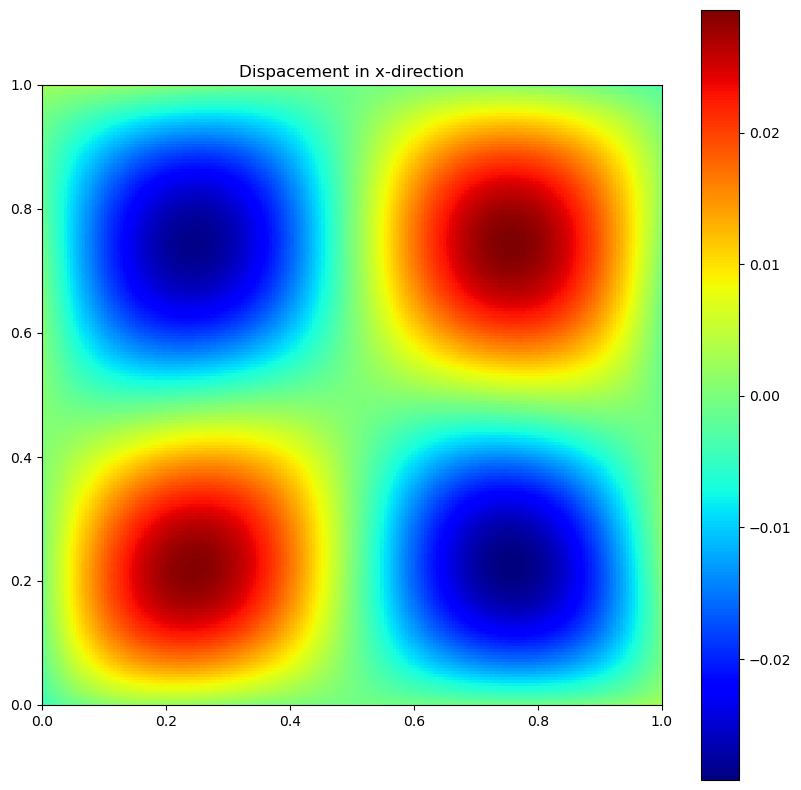

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(u_pred, cmap="jet", extent=EXTENT, origin="lower")
plt.colorbar()
plt.title("Dispacement in x-direction")
plt.savefig(os.path.join(IMAGE_DIR, "0101.png"))

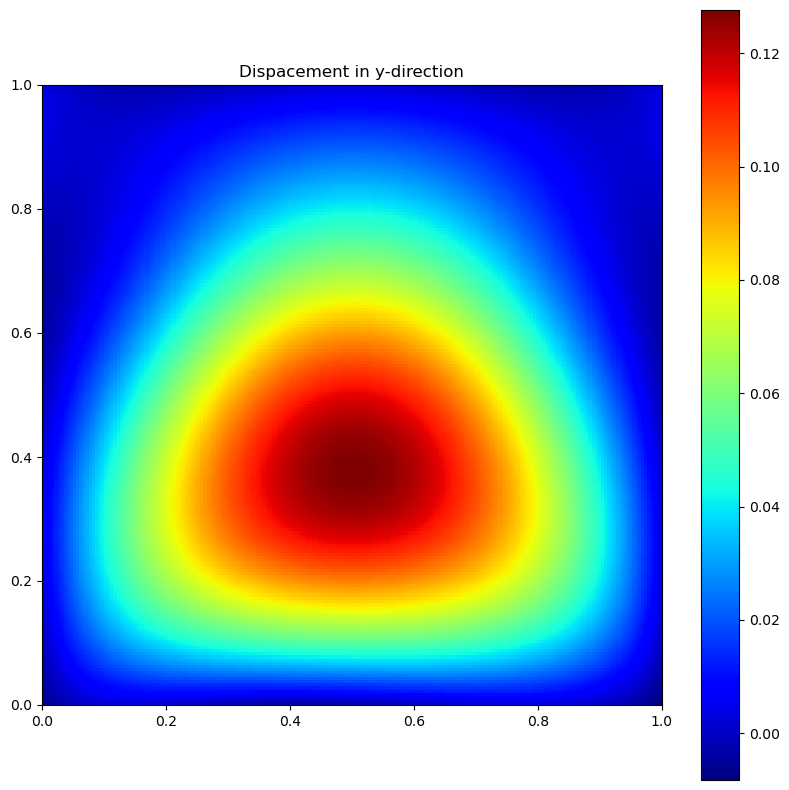

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(v_pred, cmap="jet", extent=EXTENT, origin="lower")
plt.colorbar()
plt.title("Dispacement in y-direction")
plt.savefig(os.path.join(IMAGE_DIR, "0102.png"))

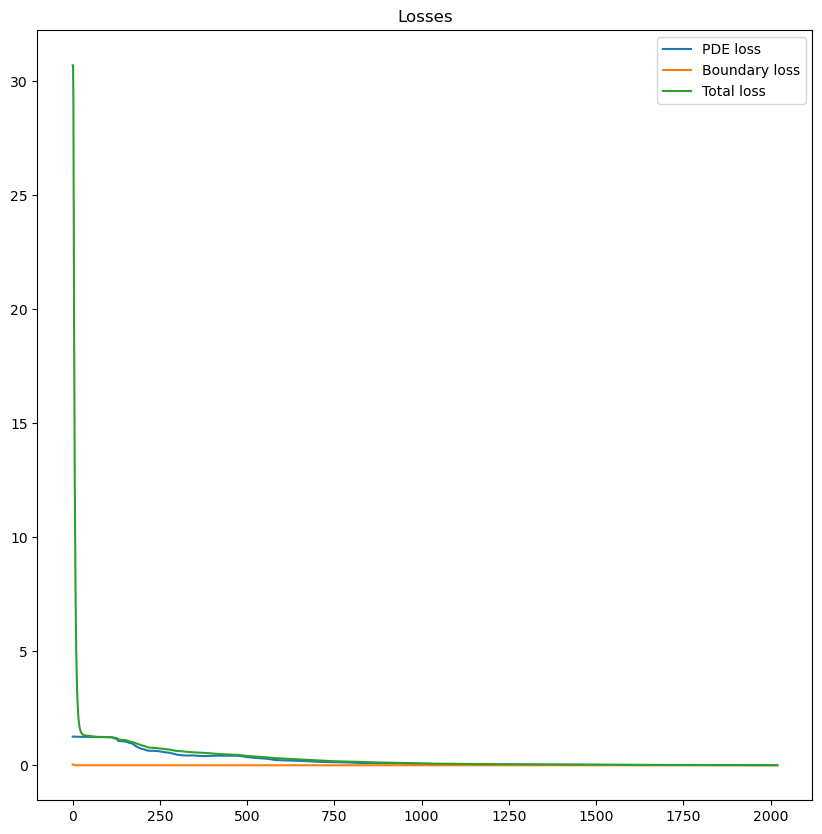

In [16]:
plt.figure(figsize=(10, 10))
plt.plot(model.pde_losses, label="PDE loss")
plt.plot(model.boundary_losses, label="Boundary loss")
plt.plot(model.total_losses, label="Total loss")
plt.legend()
plt.title("Losses")
plt.savefig(os.path.join(IMAGE_DIR, "0103.png"))